<a href="https://colab.research.google.com/github/CS7140/PA-7/blob/main/Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rajesh Sakhamuru

11-7-2020
# ResNet Implementation
ResNet implementation is below:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
with strategy.scope():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

    train_labels = tf.convert_to_tensor(train_labels)
    test_labels = tf.convert_to_tensor(test_labels)

    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

    # resizes images and pads resized image with 0s so convolutions+pooling don't shrink
    # resolution too much
    train_images = tf.image.resize_with_pad(train_images, 112, 112)
    test_images = tf.image.resize_with_pad(test_images, 112, 112)

    train_images = tf.convert_to_tensor((train_images) / 255)
    test_images = tf.convert_to_tensor((test_images) / 255)


In [4]:
class residualBlock(tf.keras.Model):
    def __init__(self, numFilters=3, use1x1Conv=False, strides=1):
        super().__init__()
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(numFilters, padding='same', kernel_size=3, strides=strides),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Conv2D(numFilters, padding='same', kernel_size=3, strides=1),
            tf.keras.layers.BatchNormalization()])
        self.oneXoneBlock = None
        if use1x1Conv:
            self.oneXoneBlock = tf.keras.layers.Conv2D(numFilters, kernel_size=1, strides=strides)

    def call(self, X):
        Y = self.block(X)
        if self.oneXoneBlock is not None:
            X = self.oneXoneBlock(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [5]:
def resNet18(lr=0.05):
    resNet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(112, 112, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        residualBlock(numFilters=64),
        residualBlock(numFilters=64),
        residualBlock(numFilters=128, use1x1Conv=True, strides=2),
        residualBlock(numFilters=128),
        residualBlock(numFilters=256, use1x1Conv=True, strides=2),
        residualBlock(numFilters=256),
        residualBlock(numFilters=512, use1x1Conv=True, strides=2),
        residualBlock(numFilters=512),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    resNet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return resNet

In [6]:
def plotAccuracyAndLoss(history, epochs):
    plt.title("Train vs Test Accuracy over Epochs")
    plt.plot(range(1,epochs+1), history.history['accuracy'], 'b-', label='train accuracy')
    plt.plot(range(1,epochs+1), history.history['val_accuracy'], 'r-', label='test accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch number")
    plt.legend()
    plt.show()

    plt.title("Train vs Test Loss over Epochs")
    plt.plot(range(1,epochs+1), history.history['loss'], 'b-', label='train loss')
    plt.plot(range(1,epochs+1), history.history['val_loss'], 'r-', label='test loss')
    plt.ylabel("loss")
    plt.xlabel("epoch number")
    plt.legend()
    plt.show()

Epoch 1/10
469/469 - 55s - loss: 0.4453 - accuracy: 0.8416 - val_loss: 0.5523 - val_accuracy: 0.8120
Epoch 2/10
469/469 - 52s - loss: 0.2431 - accuracy: 0.9099 - val_loss: 0.4348 - val_accuracy: 0.8443
Epoch 3/10
469/469 - 53s - loss: 0.1865 - accuracy: 0.9316 - val_loss: 0.3302 - val_accuracy: 0.8771
Epoch 4/10
469/469 - 53s - loss: 0.1461 - accuracy: 0.9462 - val_loss: 0.3457 - val_accuracy: 0.8810
Epoch 5/10
469/469 - 52s - loss: 0.1137 - accuracy: 0.9585 - val_loss: 0.4849 - val_accuracy: 0.8466
Epoch 6/10
469/469 - 52s - loss: 0.0825 - accuracy: 0.9708 - val_loss: 0.2824 - val_accuracy: 0.9098
Epoch 7/10
469/469 - 53s - loss: 0.0589 - accuracy: 0.9789 - val_loss: 0.5086 - val_accuracy: 0.8715
Epoch 8/10
469/469 - 53s - loss: 0.0467 - accuracy: 0.9840 - val_loss: 0.4417 - val_accuracy: 0.8693
Epoch 9/10
469/469 - 53s - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.3233 - val_accuracy: 0.9141
Epoch 10/10
469/469 - 53s - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.3052 - val_accura

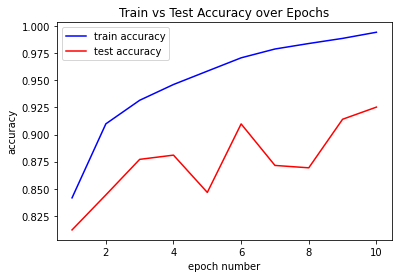

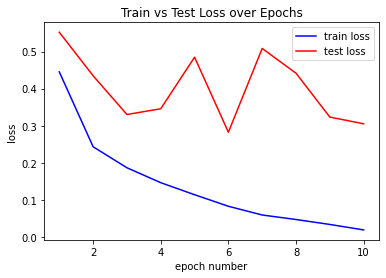

In [13]:
with strategy.scope():
    resNet = resNet18(lr=0.05)
    history1 = resNet.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), verbose=2)
    plotAccuracyAndLoss(history1,10)

We cannot just increase the complexity of function without bound, even if the function classes are nested. In the case of non-nested function classes, a larger function class does not guarantee that the function will be any closer to the "truth" function. Only if the larger functions contain the smaller ones can increasing complexity can the function be more expressive and potentially reduce training errors. 

However, even in the case where function classes are nested, arbitrarily increasing complexity of functions without bound the increased complexity does not bring the function any closer to the "truth" function which we are trying to find, because we don't know if the "truth" function is within the function of increased complexity or not. Additionally, overly complex functions tend to overfit to the training data while not improving at all the performance on testing data compared to simpler functions.

In [9]:
resNet.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 56, 56, 64)        3200      
_________________________________________________________________
batch_normalization_17 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
residual_block_8 (residualBl (None, 28, 28, 64)        74368     
_________________________________________________________________
residual_block_9 (residualBl (None, 28, 28, 64)        74368     
_________________________________________________________________
residual_block_10 (residualB (None, 14, 14, 128)     